In [ ]:
import os
import h5py
import scipy.io
from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms
from PIL import Image
import zipfile 
import gdown

In [ ]:

data_root = 'Data/celeba'
import zipfile 
from zipfile import *
dataset_folder = f'{data_root}/img_align_celeba'

url = 'https://drive.google.com/uc?id=1cNIac61PSA_LqDFYFUeyaQYekYPc75NH'


download_path = f'{data_root}/img_celeba'


if not os.path.exists(data_root):
  os.makedirs(data_root)
  os.makedirs(dataset_folder)

gdown.download(url, download_path, quiet=False)

with zipfile.ZipFile(download_path, 'r') as ziphandler:
  ziphandler.extractall(dataset_folder)

Downloading...
From: https://drive.google.com/uc?id=1cNIac61PSA_LqDFYFUeyaQYekYPc75NH
To: /content/Data/celeba/img_celeba
1.44GB [00:15, 95.8MB/s]


In [ ]:
def load_images(path,limit = 128):

  files = os.listdir(path)
  images_arr = []
  n = len(files)
  i = 0 
  while(i < limit):
    images_arr.append(plt.imread(path + '/' + files[i]) / 255)
    i += 1
  return np.array(images_arr)

Size of the Dataset : (128, 218, 178, 3)


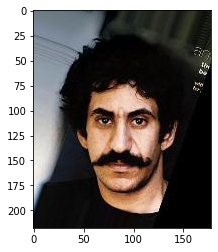

In [ ]:

PATH = "/content/Data/celeba/img_align_celeba/img_align_celeba"
data = load_images(PATH)
print(f'Size of the Dataset : {data.shape}')
plt.imshow(data[4])

In [ ]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
from torch.utils.data import DataLoader

data_tensor = torch.tensor(data).float().to(device)
num_size = 120
X_train_tensor = data_tensor[:num_size]
X_test_tensor = data_tensor[num_size:]

batch_size = 4
dataloaders = {
    'train': DataLoader(X_train_tensor, batch_size=batch_size, shuffle=False),
}

In [ ]:
import os
import gdown
data_root = '/content/Biofacenet_matlab/'
import zipfile 
from zipfile import *
dataset_folder = f'{data_root}/'
download_path = f'{data_root}/'

if not os.path.exists(data_root):
  os.makedirs(data_root)
os.chdir(data_root)
%pwd
!git clone https://github.com/ssma502/BioFaces.git

fatal: destination path 'BioFaces' already exists and is not an empty directory.


In [ ]:
dir = "/content/Biofacenet_matlab/BioFaces/util/"
destination_dir = "/content/Biofacenet_matlab/npy/"

if not os.path.exists(destination_dir):
  os.makedirs(destination_dir)
for files in os.listdir(dir):
  file_mat = scipy.io.loadmat(dir + files)
  file_mat_keys = list(file_mat.keys())
  name = file_mat_keys[3]
  value = file_mat[name]
  np.save(destination_dir + str(name) + ".npy", value )
  globals()[f"{name}"] = np.load(destination_dir+ str(name) + ".npy", allow_pickle = True)

# CameraSensitivityPCA.m : 

In [ ]:
def CameraSensitivityPCA(cmf):
  """
  Compute the Principal components of the camera measurements
  -------------------------------------------------
  Input:
        cmf
  
  Output:
        Principal components, mean, singular values
  """
  X = np.zeros((99,28))
  Y = np.zeros((99,28))
  redS = cmf[0]
  greenS = cmf[1]
  blueS = cmf[2]

  Y[:33,:] = redS/np.sum(redS,axis = 1,keepdims=True)
  Y[33:66,:] = greenS/np.sum(greenS,axis = 1,keepdims=True)
  Y[66:,:] = blueS/np.sum(blueS,axis = 1,keepdims=True)

  pca = PCA(n_components = 2)
  out = pca.fit(Y.T)
  singular_values = out.singular_values_[:2]
  return out.components_,out.mean_,singular_values


# cameraModel.m : Sensitivity parameters for the three channels

In [ ]:
def camera_model(mu,PC,b,wavelength,singular_values):
  relu = torch.nn.ReLU()
  S = b @ singular_values @ PC + mu
  S = relu(S)
  Sr = S[:,:wavelength]
  Sg = S[:,wavelength:2* wavelength]
  Sb = S[:,2*wavelength:]
  Sr = Sr.view(Sr.shape[0],Sr.shape[1],1,1)
  Sg = Sg.view(Sg.shape[0],Sg.shape[1],1,1)
  Sb = Sb.view(Sb.shape[0],Sb.shape[1],1,1)
  return Sr,Sg,Sb

# computelightcolour.m

In [ ]:
def computelightcolor(e,Sr,Sg,Sb):
  """
  Compute raw sensor values
  -------------------------------------------------
  Input:
        e,Sr,Sg,Sb
  
  Output:
        lightcolor
  """
  s1 = torch.sum(Sr * e,dim = 1,keepdims = True)
  s2 = torch.sum(Sg * e,dim = 1,keepdims = True)
  s3 = torch.sum(Sb * e,dim = 1,keepdims = True)
  lightcolor = torch.cat((s1,s2,s3),dim = 1)
  return lightcolor

# computeSpecularities.m

In [ ]:
def computeSpecularities(specmask, lightcolor):
  """
  Compute specular map
  -------------------------------------------------
  Input:
        specmask,lightcolor
  
  Output:
        spec
  """
  spec = specmask * lightcolor
  spec = torch.sum(spec,dim=1,keepdims = True)
  return spec

# WhiteBalance.m

In [ ]:

def white_balance(rawAppearance,lightcolor):
  """
  White balance the image
  -------------------------------------------------
  Input:
        rawAppearance,lightcolor
  
  Output:
        wbalanced
  """
  wbalanced = rawAppearance / lightcolor
  return wbalanced


# findT.m

In [ ]:
def findT(Tmatrix, BGrid):
  """
  Compute T_raw2xyz
  -------------------------------------------------
  Input:
        Tmatrix,b
  
  Output:
        T_RAW2XYZ
  """
  b_grid = b.view(b.shape[0],1,1,b.shape[1])
  Tmatrix = Tmatrix.permute(0,3,1,2)
  T_RAW2XYZ = torch.nn.functional.grid_sample(Tmatrix,b_grid, mode='bilinear')
  return T_RAW2XYZ

# fromRawTosRGB.m

In [ ]:
def fromRawTosRGB(wb,T_raw2xyz):
  """
  Compute the rgb values
  -------------------------------------------------
  Input:
        wb,T_raw2xyz
  
  Output:
        sRGBim
  """
  Ix = wb[:,0,:,:] * T_raw2xyz[:,0] + wb[:,1,:,:] * T_raw2xyz[:,3] + wb[:,2,:,:] * T_raw2xyz[:,6]
  Iy = wb[:,0,:,:] * T_raw2xyz[:,1] + wb[:,1,:,:] * T_raw2xyz[:,4] + wb[:,2,:,:] * T_raw2xyz[:,7]
  Iz = wb[:,0,:,:] * T_raw2xyz[:,2] + wb[:,1,:,:] * T_raw2xyz[:,5] + wb[:,2,:,:] * T_raw2xyz[:,8]


  Ix = Ix.view((-1,1,Ix.shape[1],Ix.shape[2]))
  Iy = Iy.view((-1,1,Iy.shape[1],Iy.shape[2]))
  Iz = Iz.view((-1,1,Iz.shape[1],Iz.shape[2]))


  Ixyz = torch.cat((Ix,Iy,Iz),dim = 1)
  Txyzrgb = torch.tensor([3.2406, -1.5372, -0.4986,-0.9689, 1.8758, 0.0415,0.0557, -0.2040, 1.057])

  R = Txyzrgb[0] * Ixyz[:,0,:,:] + Txyzrgb[3] * Ixyz[:,1,:,:] + Txyzrgb[6] * Ixyz[:,2,:,:]
  G = Txyzrgb[1] * Ixyz[:,0,:,:] + Txyzrgb[4] * Ixyz[:,1,:,:] + Txyzrgb[7] * Ixyz[:,2,:,:]
  B = Txyzrgb[2] * Ixyz[:,0,:,:] + Txyzrgb[5] * Ixyz[:,1,:,:] + Txyzrgb[8] * Ixyz[:,2,:,:]
  
  R = R.view((-1,1,R.shape[1],R.shape[2]))
  G = G.view((-1,1,G.shape[1],G.shape[2]))
  B = B.view((-1,1,B.shape[1],B.shape[2]))


  sRGBim = torch.cat((R,G,B),dim = 1)

  relu = nn.ReLU()
  sRGBim = relu(sRGBim)
  return sRGBim

# BiotoSpectralRef.m

In [ ]:

Newskincolour = torch.tensor(np.load('/content/Biofacenet_matlab/npy/Newskincolour.npy')).to(device)
Newskincolour = Newskincolour.view(1,Newskincolour.shape[0],Newskincolour.shape[1],Newskincolour.shape[2])
Newskincolour = Newskincolour.permute(0,3,1,2)
Newskincolour = torch.cat(batch_size*[Newskincolour],0)
print(Newskincolour.shape)

torch.Size([4, 33, 256, 256])


In [ ]:
def BiotoSpectralRF(fmel,fblood,Newskincolor):
  fmel = fmel.view((fmel.shape[0],fmel.shape[1],fmel.shape[2],1))
  fblood = fblood.view((fblood.shape[0],fblood.shape[1],fblood.shape[2],1))
  grid = torch.cat((fmel,fblood),3)
  R_total = torch.nn.functional.grid_sample(Newskincolor,grid, mode='bilinear')
  return R_total

# ImageFormation.m

In [ ]:
def ImageFormation(R_total,Sr,Sg,Sb,e,specular,shading):
  shading = shading.view(shading.shape[0],1,shading.shape[1],shading.shape[2])

  spectraRef = R_total * e
  rChannel = torch.sum(spectraRef * Sr,axis = 1,keepdims= True)
  gChannel = torch.sum(spectraRef * Sg,axis = 1,keepdims = True)
  bChannel = torch.sum(spectraRef * Sb,axis = 1,keepdims = True)

  diffuseAldebo = torch.cat((rChannel,gChannel,bChannel), axis = 1)
  ShadedDiffuse = diffuseAldebo * shading
  rawApperance = ShadedDiffuse + specular

  return rawApperance, diffuseAldebo

# scalingNet.m

In [ ]:
def scaling(lighting,b,fmel,fblood,shading,specmask,b_size):
  softmax = nn.Softmax(dim = 1)
  sigmoid = nn.Sigmoid()

  lighting_weight = softmax(lighting[:,:-1])
  weightA = lighting_weight[:,0]
  weightD = lighting_weight[:,1]
  Fweights = lighting_weight[:,2:]
  CCT = lighting[:,14]
  CCT = ((22 - 1) / (1 + torch.exp(-CCT))) 

  b = 6 * sigmoid(b) - 3
  b = b/3

  fmel = (sigmoid(fmel)*2) - 1
  fblood = (sigmoid(fblood)*2) - 1
  shading = torch.exp(shading)
  specmask = torch.exp(specmask)

  return weightA,weightD,CCT,Fweights,b,fmel,fblood,shading,specmask


# illuminationModel.m

In [ ]:
%cd /content/Biofacenet_matlab/npy

/content/Biofacenet_matlab/npy


In [ ]:

# Download the Illumination files 

illumA = torch.tensor(np.load('illumA.npy')).to(device)
illumDmeasured = torch.tensor(np.load('illumDmeasured.npy')).to(device)
illF = torch.tensor(np.load('illF.npy')).to(device)
illumA = illumA / torch.sum(illumA,dim = 2)
illF = illF / torch.sum(illF,dim=2,keepdims = True)
illumDmeasured = illumDmeasured / torch.sum(illumDmeasured,dim = 1,keepdims = True)

illumA = illumA.view(1,1,1,33)
illumA = torch.cat([illumA] * batch_size,dim = 0)

illumDmeasured = illumDmeasured.view(1,1,22,33)
illumDmeasured = illumDmeasured.permute(0,1,3,2)
illumDmeasured = torch.cat([illumDmeasured] * batch_size,dim = 0)

illF = illF.view(1,1,33,12)
illF = torch.cat([illF] * batch_size,dim = 0)

In [ ]:
def illuminationModel(weightA,weightD,Fweights,CCT,illumA,illumDNorm,illumFNorm):
  weightA = weightA.view(weightA.shape[0],1,1,1)
  weightD = weightD.view(weightD.shape[0],1,1,1)
  Fweights = Fweights.view(Fweights.shape[0],1,1,12)
  CCT = CCT.view(CCT.shape[0],1,1,1)

  illumA = illumA * weightA
  illD = illumDNorm / CCT
  illD = torch.sum(illD,dim = 3, keepdims = True)
  
  illD = illD * weightD
  illF = torch.sum(illumFNorm*Fweights,dim = 3,keepdims = True)

  illumA = illumA.view(illumA.shape[0],1,33,1)
  e = (illumA + illD + illF)
  e = e /torch.sum(e,dim=2,keepdims = True)
  e = e.permute(0,2,1,3)
  return e

# **UNET MODEL**

*   Encoder ARCHITECTURE
*   Decoder ARCHITECTURE


In [ ]:

class Encoder(nn.Module):
  def __init__(self,in_channels):
    super(Encoder,self).__init__()

    self.conv1_down = nn.Conv2d(in_channels,32,(3,3),stride = 1,padding = 1)
    self.batchnorm1_down = torch.nn.BatchNorm2d(32)
    self.conv2_down = nn.Conv2d(32,64,(3,3),stride = 1,padding = 1)
    self.batchnorm2_down = torch.nn.BatchNorm2d(64)
    self.conv3_down = nn.Conv2d(64,128,(3,3),stride = 1,padding = 1)
    self.batchnorm3_down = torch.nn.BatchNorm2d(128)
    self.conv4_down = nn.Conv2d(128,256,(3,3),stride = 1,padding = 1)
    self.batchnorm4_down = torch.nn.BatchNorm2d(256)
    self.conv5_down = nn.Conv2d(256,512,(3,3),stride = 1,padding = 1)
    self.batchnorm5_down = torch.nn.BatchNorm2d(512)
    self.relu = nn.ReLU()
    self.max_pool = nn.MaxPool2d((2,2),stride = 2)
    self.skip_connections = []
    

  def forward(self,x):
    x = x.permute(0,3,1,2)
    x = self.conv1_down(x)
    x = self.batchnorm1_down(x)
    x = self.relu(x)
    self.skip_connections.append(x)
    x = self.max_pool(x)
    x = self.conv2_down(x)
    x = self.batchnorm2_down(x)
    x = self.relu(x)
    self.skip_connections.append(x)
    x = self.max_pool(x)
    x = self.conv3_down(x)
    x = self.batchnorm3_down(x)
    x = self.relu(x)
    self.skip_connections.append(x)
    x = self.max_pool(x)
    x = self.conv4_down(x)
    x = self.batchnorm4_down(x)
    x = self.relu(x)
    self.skip_connections.append(x)
    x = self.max_pool(x)
    x = self.conv5_down(x)
    x = self.batchnorm5_down(x)
    x = self.relu(x)


    return [x,self.skip_connections]



class Decoder(nn.Module):
  def __init__(self):
    super(Decoder,self).__init__()
    self.upsample_1 = torch.nn.Upsample(size=(27,22))
    self.conv1_up = nn.Conv2d(768,256,(3,3),stride = 1,padding = 1)
    self.batchnorm1_up = torch.nn.BatchNorm2d(256)

    self.upsample_2 = torch.nn.Upsample(size=(54,44))
    self.conv2_up = nn.Conv2d(384,128,(3,3),stride = 1,padding = 1)
    self.batchnorm2_up = torch.nn.BatchNorm2d(128)

    self.upsample_3 = torch.nn.Upsample(size=(109,89))
    self.conv3_up = nn.Conv2d(192,64,(3,3),stride = 1,padding = 1)
    self.batchnorm3_up = torch.nn.BatchNorm2d(64)
    
    self.upsample_4 = torch.nn.Upsample(size=(218,178))
    self.conv4_up = nn.Conv2d(96,32,(3,3),stride = 1,padding = 1)
    self.batchnorm4_up = torch.nn.BatchNorm2d(32)
    
    self.conv5_up = nn.Conv2d(32,1,(3,3),stride = 1,padding = 1)
    self.relu = nn.ReLU()
  
  def forward(self,latent,skip_connections):

    self.skip_connections = skip_connections
    x = self.upsample_1(latent)
    x = torch.cat((x,self.skip_connections[-1]),1)
    x = self.conv1_up(x)
    x = self.batchnorm1_up(x)
    x = self.relu(x)

    x = self.upsample_2(x)
    x = torch.cat((x,self.skip_connections[-2]),1)
    x = self.conv2_up(x)
    x = self.batchnorm2_up(x)
    x = self.relu(x)

    x = self.upsample_3(x)
    x = torch.cat((x,self.skip_connections[-3]),1)
    x = self.conv3_up(x)
    x = self.batchnorm3_up(x)
    x = self.relu(x)


    x = self.upsample_4(x)
    x = torch.cat((x,self.skip_connections[-4]),1)
    x = self.conv4_up(x)
    x = self.batchnorm4_up(x)
    x = self.relu(x)
    x = self.conv5_up(x)

    return x

class fc(nn.Module):
  def __init__(self,lightvec_size,b_size):
    super(fc,self).__init__()

    self.lightvec_size = lightvec_size
    self.b_size = b_size

    self.fc1 = nn.Linear(73216,512)
    self.batchnorm_fc1 = nn.BatchNorm1d(512)
    self.fc2 = nn.Linear(512,512)
    self.batchnorm_fc2 = nn.BatchNorm1d(512)
    self.fc3 = nn.Linear(512,self.lightvec_size + self.b_size)
  
    self.relu = nn.ReLU()
    

  def forward(self,z):


    z = torch.flatten(z,start_dim=1,end_dim=-1)
    z = self.fc1(z)
    z = self.batchnorm_fc1(z)
    z = self.relu(z)

    z = self.fc2(z)
    z = self.batchnorm_fc2(z)
    z = self.relu(z)

    z = self.fc3(z)

    light_vectors = z[:,:self.lightvec_size]
    b = z[:,self.lightvec_size:]
    return light_vectors,b

# **Loss Calculation for : prior loss, appearance loss, specularity loss and shading loss**

In [ ]:
# All the loss functions

def loss_appearance(i_rgb,i_obs):
  loss = i_rgb - i_obs
  loss_val = loss ** 2
  return torch.sum(loss_val)

def loss_camera(b):
  loss_val = b @ b.T
  return torch.sum(loss_val)

def loss_spec(i_s):
  return torch.sum(abs(i_s))

def loss_shading(si_d,i_d):
  loss = si_d - i_d
  return loss.T @ loss


def total_loss(X,sRGBimt,b,spec):
  w1,w2,w3,w4 = 1e-3,1e-4,1e-5,1e-5
  l1 = loss_appearance(sRGBimt,X)
  l2 = loss_camera(b)
  l3 = loss_spec(spec)

  loss_val = w1 * l1 + w2 * l2 + w3 * l3
  return loss_val

In [ ]:
%cd /content/Biofacenet_matlab/npy

/content/Biofacenet_matlab/npy


# **TRAINING THE MODEL**

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
# HYPERPARAMETERS
lightvec_size = 15
b_size = 2
num_classes = 4
epochs = 200
lr = 1e-5

loss_list = []

# MODELS
model_encode = Encoder(in_channels=3).to(device)
params = list(model_encode.parameters())
model_decode_list = []
for i in range(num_classes):
  m = Decoder().to(device)
  model_decode_list.append(m)
  params = params + list(m.parameters())

model_fc = fc(lightvec_size = lightvec_size, b_size = b_size).to(device)
params = params + list(model_fc.parameters())
optimizer = torch.optim.SGD(params, lr)

# TRAINING
for epoch_num in range(epochs):
  train_loss = 0
  for X in dataloaders['train']:
    optimizer.zero_grad()

    # ENCODER UNET
    latent,skip_connections = model_encode(X)
    feature_maps = []

    # DECODER UNET
    for c in range(num_classes):
      feature_maps.append(model_decode_list[c](latent,skip_connections))
    
    feature_maps_tensor= torch.cat(feature_maps,dim=1)
    fmel = feature_maps_tensor[:,0,:,:]
    fblood = feature_maps_tensor[:,1,:,:]
    shading = feature_maps_tensor[:,2,:,:]
    specmask = feature_maps_tensor[:,3,:,:]
    
    # FULLY CONNECTED DECODER
    light_vectors,b = model_fc(latent)

    #SCALING
    weightA,weightD,CCT,Fweights,b,fmel,fblood,shading,specmask = scaling(light_vectors,b,fmel,fblood,shading,specmask,b_size)
    
    #ILLUMINATION MODEL
    e = illuminationModel(weightA,weightD,Fweights,CCT,illumA,illumDmeasured,illF)

    #CAMERA MODEL
    wavelength = 33
    PC,mu,singular_values = CameraSensitivityPCA(np.array(list(rgbCMF[0])))
    PC = torch.from_numpy(PC).float().to(device)
    mu = torch.from_numpy(mu).float().to(device)
    singular_values = torch.from_numpy(singular_values).float().to(device)
    singular_values = torch.diag(singular_values)
    mu = mu.view(1,mu.shape[0])
    mu = torch.cat([mu] * batch_size,dim = 0)
    Sr,Sg,Sb = camera_model(mu,PC,b,wavelength,singular_values)

    #COMPLETE ILLUMINATION MODEL
    lightcolor = computelightcolour(e,Sr,Sg,Sb)

    # SPECULAR MASK
    specmask_changed = specmask.view(specmask.shape[0],1,specmask.shape[1],specmask.shape[2])
    spec = computeSpecularities(specmask_changed,lightcolor)

    # BIO REFLECTANCE MODEL
    R_total = BiotoSpectralRF(fmel,fblood,Newskincolour)

    # IMAGE RECONSTRUCTION
    rawAppearance,diffuseAlbedo = ImageFormation(R_total,Sr,Sg,Sb,e,spec,shading)

    # WHITE BALANCE
    wbalanced = white_balance(rawAppearance,lightcolor)

    # TMATRIX
    Tmatrix = torch.tensor(np.load('Tmatrix.npy')).to(device)
    Tmatrix = Tmatrix.view(1,Tmatrix.shape[0],Tmatrix.shape[1],Tmatrix.shape[2])
    Tmatrix = torch.cat([Tmatrix] * batch_size,dim = 0)
    T_RAW2XYZ = findT(Tmatrix,b)
    print(T_RAW2XYZ.shape)
    #COMPLETE THE IMAGE
    sRGBim = fromRawTosRGB(wbalanced,T_RAW2XYZ)
    sRGBimt = sRGBim.permute(0,2,3,1)

    #LOSS
    loss = total_loss(X,sRGBimt,b,spec)
    train_loss += loss.item()
    loss.backward()
    optimizer.step()
  loss_list.append(loss.item())
  if epoch_num% 2 == 0:
    print(f"Epoch {epoch_num} Loss Value {train_loss / batch_size}")

RuntimeError: ignored

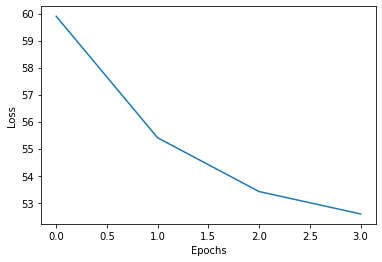

In [ ]:
epoch_list= [x for x in range(epochs)]
plt.plot(epoch_list,loss_list)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

<!-- # **TESTING ** -->

# **TESTING :**

In [ ]:
# TESTING THE MODEL

model_encode.eval()
for i in range(len(model_decode_list)):
  model_decode_list[i].eval()
model_fc.eval()

latent_test,skip_connections_test = model_encode(X_test_tensor)
feature_maps_test = []
for c in range(num_classes):
  feature_maps_test.append(model_decode_list[c](latent_test,skip_connections_test))


feature_maps_tensor_test = torch.cat(feature_maps_test,dim=1)
fmel_test = feature_maps_tensor_test[:,0,:,:]
fblood_test = feature_maps_tensor_test[:,1,:,:]
shading_test = feature_maps_tensor_test[:,2,:,:]
specmask_test = feature_maps_tensor_test[:,3,:,:]

light_vectors_test,b_test = model_fc(latent_test)


#OUTPUTS
weightA,weightD,CCT,Fweights,b,fmel_test,fblood_test,shading_test,specmask_test = scaling(light_vectors_test,b_test,fmel_test,fblood_test,shading_test,specmask_test,b_size)

RuntimeError: ignored

In [ ]:
def plot_grid(image,fmel,fblood,spec_shade,diffuse_shade):
  fig, axs = plt.subplots(1,5,figsize=(20,20))
  axs[0].imshow(fmel)
  axs[1].imshow(fblood)
  axs[2].imshow(spec_shade)
  axs[3].imshow(diffuse_shade)
  axs[4].imshow(image)

  axs[0].set_title('Melanin')
  axs[1].set_title('Haemoglobin')
  axs[2].set_title('Specular')
  axs[3].set_title('Diffused')
  axs[4].set_title('Original Image')
  return

In [ ]:
num = X_test_tensor.shape[0]
for i in range(num):
  fmel_plt = fmel_test[i].cpu().detach().numpy()
  fblood_plt = fblood_test[i].cpu().detach().numpy()
  spec_plt = specmask_test[i].cpu().detach().numpy()
  diff_plt = shading_test[i].cpu().detach().numpy()
  image = X_test_tensor[i].cpu().detach().numpy()
  plot_grid(image,fmel_plt,fblood_plt,spec_plt,diff_plt)

NameError: ignored